In [1]:
!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Memory has been reset


In [1]:
#Import Libraries

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf 
import keras
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Conv1D, BatchNormalization,MaxPooling1D, Flatten, Dropout, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '/kaggle/input/speech-datasets/CREMA-D/'

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Walk through all subfolders and files
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        file_paths.append(os.path.join(subdir, file))
        labels.append(os.path.basename(subdir))

# Create a DataFrame
data_df = pd.DataFrame({'file_path': file_paths, 'label': labels})
data_df = data_df.sort_values(by='label', ascending=True)

# Display the DataFrame
print(data_df.head())
print(data_df.label.value_counts())

                                              file_path  label
7441  /kaggle/input/speech-datasets/CREMA-D/Anger/10...  Anger
6589  /kaggle/input/speech-datasets/CREMA-D/Anger/10...  Anger
6590  /kaggle/input/speech-datasets/CREMA-D/Anger/10...  Anger
6591  /kaggle/input/speech-datasets/CREMA-D/Anger/10...  Anger
6592  /kaggle/input/speech-datasets/CREMA-D/Anger/10...  Anger
label
Anger      1271
Disgust    1271
Fear       1271
Happy      1271
Sad        1271
Neutral    1087
Name: count, dtype: int64


In [3]:
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def zcr(data,frame_length=2048,hop_length=512):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
    
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

'''def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)

def sp_bw(data, sr, frame_length=2048, hop_length=512):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_bandwidth)

def sp_rolloff(data, sr, frame_length=2048, hop_length=512):
    sp_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(sp_rolloff)

def sp_contrast(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_contrast.T) if not flatten else np.ravel(spectral_contrast.T)

def sp_flatness(data, frame_length=2048, hop_length=512, flatten: bool = True):
    spectral_flatness = librosa.feature.spectral_flatness(y=data, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_flatness.T) if not flatten else np.ravel(spectral_flatness.T)

def tnz(data, sr, flatten: bool = True):
    tonnetz = librosa.feature.tonnetz(y=data, sr=sr)
    return np.squeeze(tonnetz.T) if not flatten else np.ravel(tonnetz.T)

def tmp_gram(data, sr, flatten: bool = True):
    tempogram = librosa.feature.tempogram(y=data, sr=sr)
    return np.squeeze(tempogram) if not flatten else np.ravel(tempogram.T)

def mel_spc(data, sr, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.mean(mel.T, axis=0) if not flatten else np.ravel(mel.T)

def chroma_stft(data, sr, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(chroma_stft.T, axis=0) if not flatten else np.ravel(chroma_stft.T)

def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length

def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)
    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]
    return np.squeeze(vsf) if isSpectrum else vsf'''

def extract_features(data,sr=16000,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      mfcc(data,sr,frame_length,hop_length),
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      #spc(data,sr,frame_length,hop_length),
                      #sp_bw(data,sr,frame_length,hop_length),
                      #sp_rolloff(data,sr,frame_length,hop_length),
                      #sp_contrast(data,sr,frame_length,hop_length),
                      #sp_flatness(data,frame_length,hop_length),
                      #tnz(data, sr),
                      #tmp_gram(data, sr),
                      #mel_spc(data,sr),
                      #chroma_stft(data,sr),
                      #energy(data,frame_length,hop_length),
                      #entropy_of_energy(data,frame_length,hop_length),
                      #spc_flux(data)
                     ))
    return result

def get_features(path,duration=2.5,offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    return audio

In [4]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
samples,labels=[],[]
for path,emotion,index in tqdm (zip(data_df.file_path,data_df.label,range(data_df.file_path.shape[0]))):
    tempo=get_features(path)
    features=np.empty((0,tempo.shape[0]), dtype=object)
    features=np.vstack([features,tempo])
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        samples.append(i)
        labels.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

4it [00:18,  3.44s/it]

0 audio has been processed


504it [00:38, 15.62it/s]

500 audio has been processed


1004it [00:57, 27.08it/s]

1000 audio has been processed


1506it [01:18, 25.92it/s]

1500 audio has been processed


2004it [01:37, 24.52it/s]

2000 audio has been processed


2505it [01:58, 27.36it/s]

2500 audio has been processed


3004it [02:17, 17.85it/s]

3000 audio has been processed


3505it [02:37, 25.78it/s]

3500 audio has been processed


4005it [02:57, 29.56it/s]

4000 audio has been processed


4505it [03:15, 27.29it/s]

4500 audio has been processed


5006it [03:34, 28.44it/s]

5000 audio has been processed


5504it [03:53, 27.54it/s]

5500 audio has been processed


6006it [04:13, 27.43it/s]

6000 audio has been processed


6505it [04:33, 19.40it/s]

6500 audio has been processed


7004it [04:52, 26.51it/s]

7000 audio has been processed


7442it [05:10, 24.00it/s]

Done
Time:  310.09493463699994


In [5]:
len(samples), len(labels), data_df.file_path.shape

(7442, 7442, (7442,))

In [6]:
emotional_speech = pd.DataFrame(samples)
emotional_speech['label'] = labels
print(emotional_speech.isna().any())

0        False
1        False
2        False
3        False
4        False
         ...  
2372      True
2373      True
2374      True
2375      True
label    False
Length: 2377, dtype: bool


In [7]:
emotional_speech=emotional_speech.fillna(0)
print(emotional_speech.isna().any())
emotional_speech.shape

0        False
1        False
2        False
3        False
4        False
         ...  
2372     False
2373     False
2374     False
2375     False
label    False
Length: 2377, dtype: bool


(7442, 2377)

In [8]:
samples = emotional_speech.iloc[: ,:-1].values
labels = emotional_speech['label'].values

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print("Shape of X:", samples.shape)
print("Shape of Y:", labels.shape)

# Apply StandardScaler to the features
scaler = StandardScaler()
samples_scaled = scaler.fit_transform(samples)

Shape of X: (7442, 2376)
Shape of Y: (7442,)


In [10]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", C=10, probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    "SGD Classifier": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42)
}

# Perform 5-fold cross-validation for each model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

# Initialize dictionary to store overall confusion matrices & Classification reports
overall_confusion_matrices = {}
overall_classification_reports = {}

for name, model in models.items():
    print(f"\n{name}:")
    all_true = []
    all_pred = []
    scores = []
    for train_index, test_index in kf.split(samples_scaled, labels_encoded):
        samples_train, samples_test = samples_scaled[train_index], samples_scaled[test_index]
        labels_train, labels_test = labels_encoded[train_index], labels_encoded[test_index]

        # Train the model
        model.fit(samples_train, labels_train)

        # Validate the model
        labels_pred = model.predict(samples_test)
        accuracy = accuracy_score(labels_test, labels_pred)
        scores.append(accuracy)

        # Accumulate predictions and true labels
        all_true.extend(labels_test)
        all_pred.extend(labels_pred)

        print(f"Fold Accuracy: {accuracy * 100:.2f}%")

    avg_score = np.mean(scores)
    cv_results[name] = avg_score
    print(f"Average Accuracy for {name}: {avg_score * 100:.2f}%")

    # Calculate the overall confusion matrix & Classification Reports
    overall_cm = confusion_matrix(all_true, all_pred)
    overall_cr = classification_report(all_true, all_pred, target_names=label_encoder.classes_)
    
    overall_confusion_matrices[name] = overall_cm
    overall_classification_reports[name] = overall_cr
    print(f"Overall Confusion Matrix for {name}:\n{overall_cm}")
    print(f"Overall Classification Report for {name}:\n{overall_cr}")


Logistic Regression:
Fold Accuracy: 99.19%
Fold Accuracy: 99.46%
Fold Accuracy: 99.19%
Fold Accuracy: 99.33%
Fold Accuracy: 99.26%
Average Accuracy for Logistic Regression: 99.29%
Overall Confusion Matrix for Logistic Regression:
[[1271    0    0    0    0    0]
 [   0 1254   17    0    0    0]
 [   1   14 1247    2    0    7]
 [   8    2    0 1261    0    0]
 [   0    1    0    0 1086    0]
 [   0    1    0    0    0 1270]]
Overall Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       Anger       0.99      1.00      1.00      1271
     Disgust       0.99      0.99      0.99      1271
        Fear       0.99      0.98      0.98      1271
       Happy       1.00      0.99      1.00      1271
     Neutral       1.00      1.00      1.00      1087
         Sad       0.99      1.00      1.00      1271

    accuracy                           0.99      7442
   macro avg       0.99      0.99      0.99      7442
weighted avg       0.99    

(7442, 6)

Fold 1:
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Fold Accuracy: 100.00%

Fold 2:
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Fold Accuracy: 100.00%

Fold 3:
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Fold Accuracy: 99.93%

Fold 4:
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Fold Accuracy: 99.93%

Fold 5:
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Fold Accuracy: 99.80%
Average Accuracy: 99.93%


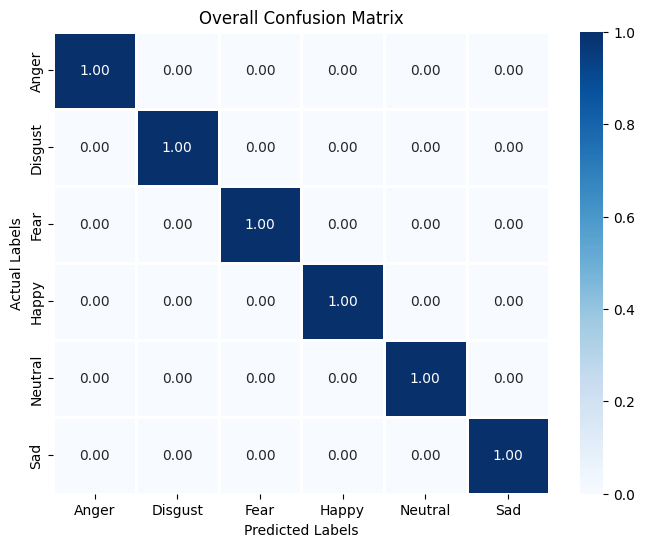


Overall Confusion Matrix:
[[1269    1    0    1    0    0]
 [   0 1270    0    1    0    0]
 [   0    0 1271    0    0    0]
 [   1    0    0 1270    0    0]
 [   0    0    0    0 1087    0]
 [   0    1    0    0    0 1270]]

Overall Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00      1271
     Disgust       1.00      1.00      1.00      1271
        Fear       1.00      1.00      1.00      1271
       Happy       1.00      1.00      1.00      1271
     Neutral       1.00      1.00      1.00      1087
         Sad       1.00      1.00      1.00      1271

    accuracy                           1.00      7442
   macro avg       1.00      1.00      1.00      7442
weighted avg       1.00      1.00      1.00      7442


Overall Accuracy:
0.99932813759742


In [12]:
# One-hot encode labels
encoder = OneHotEncoder()
labels_OHencoded = encoder.fit_transform(np.array(labels).reshape(-1, 1)).toarray()
print(labels_OHencoded.shape)

# Scaling features
scaler = StandardScaler()
samples_cnn = scaler.fit_transform(samples)

# Reshape for CNN input
samples_cnn = np.expand_dims(samples_cnn, axis=2)

# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

        tf.keras.layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

        tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

        tf.keras.layers.Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
overall_true = []
overall_pred = []
scores = []
fold = 1

for train_index, test_index in kf.split(samples_scaled, labels):
    print(f"\nFold {fold}:")
    samples_train, samples_test = samples_cnn[train_index], samples_cnn[test_index]
    labels_train, labels_test = labels_OHencoded[train_index], labels_OHencoded[test_index]

    model = create_cnn_model(input_shape=(samples_train.shape[1], 1), num_classes=labels_train.shape[1])

    # Save best model weights
    checkpoint_filepath = f'best_model_fold_{fold}.keras'
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

    model.fit(samples_train, labels_train, epochs=100, validation_data=(samples_test, labels_test), batch_size=64, callbacks=[model_checkpoint], verbose=0)

    # Load best model weights
    model.load_weights(checkpoint_filepath)

    labels_pred = model.predict(samples_test)
    labels_pred = np.argmax(labels_pred, axis=1)
    labels_true = np.argmax(labels_test, axis=1)
    accuracy = accuracy_score(labels_true, labels_pred)
    scores.append(accuracy)

    overall_true.extend(labels_true)
    overall_pred.extend(labels_pred)
    
    print(f"Fold Accuracy: {accuracy * 100:.2f}%")
    fold += 1

avg_score = np.mean(scores)
print(f"Average Accuracy: {avg_score * 100:.2f}%")
# Overall confusion matrix and classification report
cm = confusion_matrix(overall_true, overall_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues', linecolor='white', linewidths=1)
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

print("\nOverall Confusion Matrix:")
print(confusion_matrix(overall_true, overall_pred))
print("\nOverall Classification Report:")
print(classification_report(overall_true, overall_pred, target_names=encoder.categories_[0]))
print("\nOverall Accuracy:")
print(accuracy_score(overall_true, overall_pred))

In [ ]:
epochs = [i for i in range(100)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (8,5))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()